<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Cross_to_shots_Expected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
##############################################
# STEP 0: MOUNT GOOGLE DRIVE (COLAB)
##############################################
from google.colab import drive
drive.mount('/content/drive')

##############################################
# STEP 1: IMPORT LIBRARIES
##############################################
import pandas as pd
import numpy as np

# For splitting data, building model, and evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

##############################################
# STEP 2: LOAD DATA FROM GOOGLE DRIVE
##############################################
# Adjust this path to point to your BM2425.xlsx in Drive
excel_file_path = '/content/drive/MyDrive/BM2425.xlsx'
df = pd.read_excel(excel_file_path)

##############################################
# STEP 3: SORT BY 'timeStamp' & SHIFT typeId
##############################################
# If 'timeStamp' is a datetime string, make sure it's parsed or at least consistent.
# If it's just a numeric or string that sorts chronologically, this works directly.
df = df.sort_values('timeStamp').reset_index(drop=True)

df['next_1_typeId'] = df['typeId'].shift(-1)
df['next_2_typeId'] = df['typeId'].shift(-2)
df['next_3_typeId'] = df['typeId'].shift(-3)

##############################################
# STEP 4: DEFINE leads_to_shot
##############################################
df['leads_to_shot'] = 0  # default

valid_shot_ids = [13, 14, 15, 16]  # these typeIds lead to shot
df.loc[
    (df['Cross'] == 1) & (
        df['next_1_typeId'].isin(valid_shot_ids) |
        df['next_2_typeId'].isin(valid_shot_ids) |
        df['next_3_typeId'].isin(valid_shot_ids)
    ),
    'leads_to_shot'
] = 1

# (Optional) Preview the result
print("\n--- DataFrame After Adding leads_to_shot ---")
print(df.head(20))  # check the first 20 rows

##############################################
# STEP 5: FEATURE ENGINEERING
##############################################
# Example: Combine timeMin & timeSec -> totalTime
df['totalTime'] = df['timeMin'] * 60 + df['timeSec']

# Let's define our target
y = df['leads_to_shot']

# Example feature columns: adjust to what you actually have/need
# If some columns don't exist, remove or replace them
feature_cols = [
    'periodId',
    'totalTime',
    'x', 'y',
    'endX', 'endY',
    'outcome',    # If this is 1=success, 0=fail or a similar numeric
    'Corner',
    'Cutback',
    'LongBall'
]

# Make sure all columns exist before proceeding
for col in feature_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in df. Removing from feature_cols.")
        feature_cols.remove(col)

# Build your feature matrix X
X = df[feature_cols].copy()

# Ensure columns that are booleans or 0/1 are actually numeric
# For example:
bool_cols = ['Corner','Cutback','LongBall']
for c in bool_cols:
    if c in X.columns:
        X[c] = X[c].astype(int)  # Convert to 0/1 if not already

# If 'outcome' is text like "Successful"/"Unsuccessful", you need to map it:
# outcome_mapping = {"Successful": 1, "Unsuccessful": 0}
# X['outcome'] = X['outcome'].map(outcome_mapping)

# (Optional) Check for missing values or strange data
# print(X.isna().sum())

##############################################
# STEP 6: SPLIT INTO TRAIN & TEST
##############################################
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,     # reproducibility
    stratify=y           # preserve class distribution if possible
)

print("\n--- Data Splits ---")
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

##############################################
# STEP 7: TRAIN MODELS
##############################################

# (A) Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# (B) Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

##############################################
# STEP 8: EVALUATE
##############################################
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_lr), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

print("\n=== Random Forest Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_rf), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- DataFrame After Adding leads_to_shot ---
            id  eventId  typeId  periodId  timeMin  timeSec  \
0   2713245567        1      34        16        0        0   
1   2713246813        1      34        16        0        0   
2   2713302913        2      32         1        0        0   
3   2713302931        2      32         1        0        0   
4   2713303059        3       1         1        0        0   
5   2713303085        4       1         1        0       14   
6   2713303097        3       1         1        0       18   
7   2713303099        4      61         1        0       19   
8   2713303111        5       1         1        0       21   
9   2713303137        6       1         1        0       22   
10  2713303165        7       1         1        0       23   
11  2713303195        8       1         1        0       26   
12  27

In [31]:
# (A) Filter only cross events
crosses_df = df[df['Cross'] == 1].copy()

# (B) Build the same feature matrix (X_crosses) with the same feature_cols
X_crosses = crosses_df[feature_cols].copy()

# Ensure conversions match training
for bcol in bool_cols:
    if bcol in X_crosses.columns:
        X_crosses[bcol] = X_crosses[bcol].astype(int)

# (C) Predict probabilities with, say, the Random Forest
cross_shot_probs = rf_model.predict_proba(X_crosses)[:, 1]

# (D) Attach these probabilities back to crosses_df
crosses_df['shot_probability'] = cross_shot_probs

# (E) If you want to merge these back to the original df:
df['shot_probability'] = np.nan
df.loc[crosses_df.index, 'shot_probability'] = crosses_df['shot_probability']

print("\n--- Probability of Leading to a Shot for Crosses ---")
print(crosses_df[['id', 'playerName', 'contestantId', 'Cross','typeId','shot_probability']].head(20))

# Now, 'crosses_df' includes 'shot_probability' for each cross event
# and 'df' has 'shot_probability' for cross rows (NaN for non-cross rows).


--- Probability of Leading to a Shot for Crosses ---
              id   playerName               contestantId  Cross  typeId  \
147   2713308959      S. Boey  apoawtpvac4zqlancmvw4nk4o      1       1   
154   2713309661   J. Kimmich  apoawtpvac4zqlancmvw4nk4o      1       1   
189   2713312197     M. Olise  apoawtpvac4zqlancmvw4nk4o      1       1   
195   2713312479   J. Kimmich  apoawtpvac4zqlancmvw4nk4o      1       1   
272   2713315339   J. Kimmich  apoawtpvac4zqlancmvw4nk4o      1       1   
631   2713326399     M. Olise  apoawtpvac4zqlancmvw4nk4o      1       1   
736   2713330121      H. Kane  apoawtpvac4zqlancmvw4nk4o      1       1   
820   2713334525    M. Arnold  a8l3w3n0j99qjlsxj3jnmgkz1      1       1   
822   2713334609   K. Fischer  a8l3w3n0j99qjlsxj3jnmgkz1      1       1   
877   2713348481      S. Boey  apoawtpvac4zqlancmvw4nk4o      1       1   
940   2713350883    S. Gnabry  apoawtpvac4zqlancmvw4nk4o      1       1   
1037  2713354983  A. Pavlović  apoawtpvac4zqla

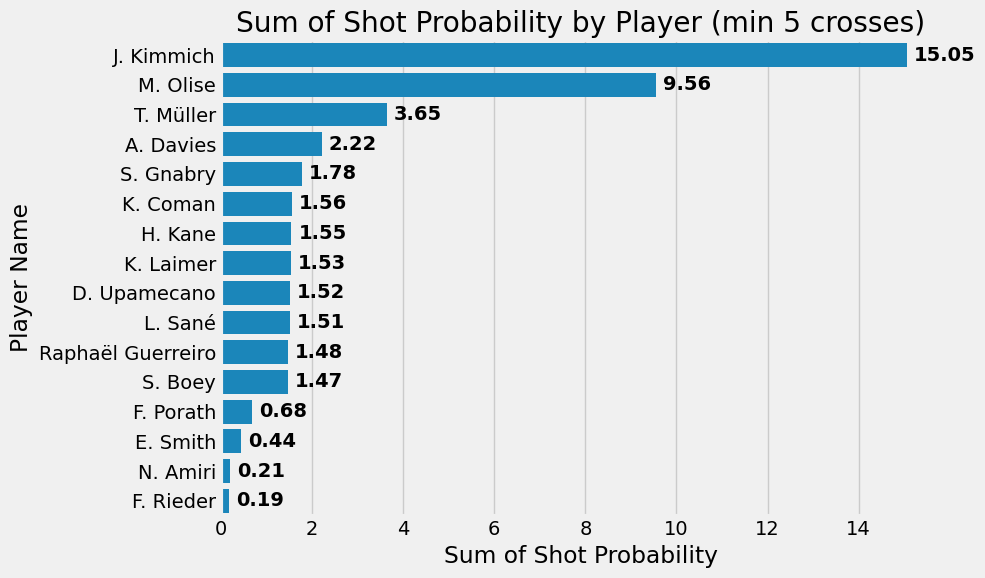

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the fivethirtyeight style
plt.style.use('fivethirtyeight')

# 1) Sum of shot_probability by playerName
player_probs = crosses_df.groupby('playerName', dropna=True)['shot_probability'].sum().reset_index()
player_probs.rename(columns={'shot_probability': 'sum_shot_prob'}, inplace=True)

# 2) Sort descending by sum of probabilities
player_probs = player_probs.sort_values('sum_shot_prob', ascending=False)

# 3) (Optional) Filter out players with fewer than 5 crosses
cross_counts = crosses_df.groupby('playerName').size().reset_index(name='cross_count')
player_probs = player_probs.merge(cross_counts, on='playerName')
player_probs = player_probs[player_probs['cross_count'] >= 5]

# 4) Create a horizontal bar plot: x = sum_shot_prob, y = playerName
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=player_probs,
    x='sum_shot_prob',
    y='playerName',
    order=player_probs['playerName']  # ensures the sorted order
)

# 5) Add labels at the end of each bar, formatted to 2 decimals
for p in ax.patches:
    # p.get_width()  = bar's length (x-value)
    # p.get_y() + p.get_height()/2 = vertical center of the bar
    ax.annotate(
        f"{p.get_width():.2f}",            # format to 2 decimals
        (p.get_width(), p.get_y() + p.get_height()/2),
        xytext=(5, 0),                     # 5 points to the right of the bar
        textcoords='offset points',
        ha='left',
        va='center',
        color='black',
        weight='bold'
    )

plt.title("Sum of Shot Probability by Player (min 5 crosses)")
plt.xlabel("Sum of Shot Probability")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()
